# Early Fusion Transformer Model - CMU-MOSEI Dataset

## Importing Libraries

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 367 (delta 102), reused 152 (delta 50), pack-reused 141 (from 1)
Receiving objects: 100% (367/367), 279.93 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Updating files: 100% (56/56), done.


In [2]:
!pip install memory_profiler

In [3]:
import gdown

file_id = "180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz"
destination = "mosei_senti_data.pkl"  # Name to save the file as

# Download the file
gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz
From (redirected): https://drive.google.com/uc?id=180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz&confirm=t&uuid=33c032fd-f45a-4035-91e3-57eaa117f72e
To: /content/mosei_senti_data.pkl
100%|██████████| 3.73G/3.73G [00:56<00:00, 65.8MB/s]


'mosei_senti_data.pkl'

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import Transformer, MLP, Sequential, Identity
from training.supervised import train, test
from fusions.modules import ConcatEarly
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
FILE_PATH = '/content/mosei_senti_data.pkl'
train_data, valid_data, test_data = get_dataloader(FILE_PATH)

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
encoders = [Identity().to(device), Identity().to(device), Identity().to(device)]
head = Sequential(Transformer(409, 300).to(device), MLP(300, 128, 1)).to(device)
fusion = ConcatEarly().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Training

In [10]:
OUTPUT_MODEL_FILE_NAME = "MOSEI_Early_Fusion_Transformer"
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    200,
    task="regression",
    optimtype=torch.optim.AdamW,
    is_packed=True,
    early_stop=True,
    lr=1e-4,
    save=f"/content/Multimodal-Sentiment-Analysis/src/models/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/200]
Train Loss: 0.8130
Valid Loss: 0.7685
Saving Best

Epoch [2/200]
Train Loss: 0.8001
Valid Loss: 0.7311
Saving Best

Epoch [3/200]
Train Loss: 0.7869
Valid Loss: 0.7142
Saving Best

Epoch [4/200]
Train Loss: 0.7793
Valid Loss: 0.7135
Saving Best

Epoch [5/200]
Train Loss: 0.7731
Valid Loss: 0.7180

Epoch [6/200]
Train Loss: 0.7550
Valid Loss: 0.7249

Epoch [7/200]
Train Loss: 0.7516
Valid Loss: 0.7014
Saving Best

Epoch [8/200]
Train Loss: 0.7245
Valid Loss: 0.6657
Saving Best

Epoch [9/200]
Train Loss: 0.7055
Valid Loss: 0.7119

Epoch [10/200]
Train Loss: 0.6825
Valid Loss: 0.6456
Saving Best

Epoch [11/200]
Train Loss: 0.6675
Valid Loss: 0.6356
Saving Best

Epoch [12/200]
Train Loss: 0.6608
Valid Loss: 0.6291
Saving Best

Epoch [13/200]
Train Loss: 0.6536
Valid Loss: 0.6272
Saving Best

Epoch [14/200]
Train Loss: 0.6497
Valid Loss: 0.6099
Saving Best

Epoch [15/200]
Train Loss: 0.6371
Valid Loss: 0.6198

Epoch [16/200]
Train Loss: 0.6387
Valid Loss: 0.6305

Epoch [17/200

Text(0.5, 1.0, 'Loss vs. No. of epochs')

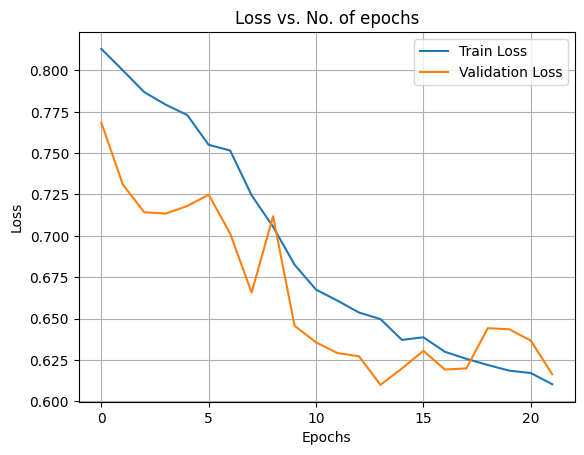

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [15]:
save_results(train_losses, valid_losses, f'/content/Multimodal-Sentiment-Analysis/src/results/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [18]:
model = torch.load(
    f"/content/Multimodal-Sentiment-Analysis/src/models/{OUTPUT_MODEL_FILE_NAME}.pt"
).to(device)

test(
    model,
    test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-18-82c888dfd27c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/content/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(devic

Recall: 80.0276% | Total Accuracy: 69.6317%
Inference Time: 2s619ms
Inference Params: 8129097
